# Multiclass classification with novel classes

In [25]:
import pandas as pd
import numpy as np
import gc
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

from mclearn.preprocessing import balanced_train_test_split
%matplotlib inline

## Loading and preprocessing data

In [2]:
sdss = pd.io.parsers.read_csv("../data/sdss_dr7_photometry.csv.gz", compression="gzip")
print(sdss.shape)
print(sdss.columns.values)

(2801002, 27)
['ra' 'dec' 'class' 'redshift' 'redshiftErr' 'psfMag_u' 'psfMagErr_u'
 'psfMag_g' 'psfMagErr_g' 'psfMag_r' 'psfMagErr_r' 'psfMag_i' 'psfMagErr_i'
 'psfMag_z' 'psfMagErr_z' 'petroMag_u' 'petroMagErr_u' 'petroMag_g'
 'petroMagErr_g' 'petroMag_r' 'petroMagErr_r' 'petroMag_i' 'petroMagErr_i'
 'petroMag_z' 'petroMagErr_z' 'petroRad_r' 'petroRadErr_r']


In [3]:
sdss['psf_u_g'] = sdss['psfMag_u'] - sdss['psfMag_g']
sdss['psf_g_r'] = sdss['psfMag_g'] - sdss['psfMag_r']
sdss['psf_r_i'] = sdss['psfMag_r'] - sdss['psfMag_i']
sdss['psf_i_z'] = sdss['psfMag_i'] - sdss['psfMag_z']

sdss['petro_u_g'] = sdss['petroMag_u'] - sdss['petroMag_g']
sdss['petro_g_r'] = sdss['petroMag_g'] - sdss['petroMag_r']
sdss['petro_r_i'] = sdss['petroMag_r'] - sdss['petroMag_i']
sdss['petro_i_z'] = sdss['petroMag_i'] - sdss['petroMag_z']

colour_features = ['psfMag_i', 'petroMag_i', 'petroRad_r',
                   'psf_u_g', 'psf_g_r', 'psf_r_i', 'psf_i_z',
                   'petroMag_r', 'petro_u_g', 'petro_g_r', 'petro_r_i',
                   'petro_i_z']
relevant_inputs = ['ra', 'dec', 'class'] + colour_features

sdss = sdss[relevant_inputs]
gc.collect()
sdss.shape

(2801002, 15)

## Train a committee of Logistic Regression classifiers

In [13]:
committee_size = 11
logistic_committee=[]
for ix in range(committee_size):
    logistic_committee.append(LogisticRegression(random_state=2, class_weight='auto'))

    
train_size = 100000
test_size = 200000
sub_train_size = 10000
X_train, X_test, y_train, y_test = balanced_train_test_split(sdss, colour_features, "class", train_size, test_size)

poly_features = PolynomialFeatures(degree=3, interaction_only=False, include_bias=False)
sdss_poly_features_3 = poly_features.fit_transform(X_train)



In [14]:
test_features = poly_features.fit_transform(X_test)
y_pred = []
for classifier in logistic_committee:
    feat, lab = shuffle(sdss_poly_features_3, y_train)
    classifier.fit(feat[:sub_train_size], lab[:sub_train_size])
    y_pred.append(classifier.predict(test_features))

Some sanity checking

In [15]:
for ix in range(3):
    cur_pred = y_pred[ix]
    conf_mat = confusion_matrix(y_test, cur_pred)
    print(conf_mat)
    print('Accuracy = %1.3f' % (conf_mat.trace()/conf_mat.sum()))

[[193371   4347   2282]
 [  6775 174735  18490]
 [  3221  24294 172485]]
Accuracy = 0.901
[[193156   4829   2015]
 [  6701 174040  19259]
 [  3600  24508 171892]]
Accuracy = 0.898
[[193604   4458   1938]
 [  7068 173292  19640]
 [  3587  23945 172468]]
Accuracy = 0.899


In [16]:
y_pred = np.array(y_pred)
pred_count = np.zeros((3,3*test_size), dtype=int)
for ix,lab in enumerate(['Galaxy', 'Star', 'Quasar']):
    pred_count[ix,:] = np.sum(y_pred == lab, axis=0)
pred_count[:,:15]

array([[11, 11, 11, 11, 11, 11, 11, 11, 11,  0, 11, 11,  0, 11, 11],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 11,  0,  0,  2,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  9,  0,  0]])

In [21]:
disagree_max = np.max(pred_count, axis=0) < committee_size-2
print(np.sum(disagree_max))
disagree_min = np.min(pred_count, axis=0) > 2
print(np.sum(disagree_min))

16661
124


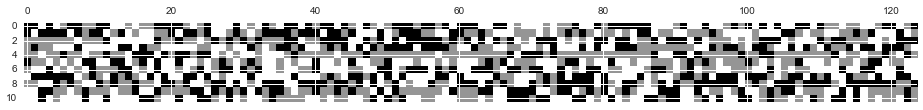

In [39]:
y_disagree = np.zeros((committee_size, np.sum(disagree_min)))
y_disagree[y_pred[:, disagree_min] == 'Galaxy'] = 0
y_disagree[y_pred[:, disagree_min] == 'Star'] = 1
y_disagree[y_pred[:, disagree_min] == 'Quasar'] = 2
plt.matshow(y_disagree)